# Mahsa Massoud 
## 810196635
## HW extra1 -Neural Networks and Deep Learning
## Question 2 - Camvid Segmentation

In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Sequential 
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, MaxPooling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from random import sample, choice
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"


In [7]:
!kaggle datasets download -d jcoral02/camvid

 99% 1.11G/1.12G [00:11<00:00, 91.9MB/s]
100% 1.12G/1.12G [00:11<00:00, 105MB/s] 


In [8]:
import zipfile

zip_ref = zipfile.ZipFile('camvid.zip', 'r') 
zip_ref.extractall('/tmp') 
zip_ref.close()

In [9]:
train_img_lst = os.listdir('/tmp/CamVid/train')
val_img_lst = os.listdir('/tmp/CamVid/val')
test_img_lst = os.listdir('/tmp/CamVid/test')

In [51]:
len(train_img_lst)

367

In [52]:
len(test_img_lst)

233

In [53]:
len(val_img_lst)

101

In [10]:
def make_pair(img_lst,image_dir,mask_dir):
    pairs = []
    #print(image_dir+img_lst[0])
    for im in img_lst:
        pairs.append((image_dir + im, mask_dir + im.split('.')[0]+'_L.png'))
        
    return pairs

In [11]:
train_pairs = make_pair(train_img_lst, "/tmp/CamVid/train/", 
                        "/tmp/CamVid/train_labels/")

val_pairs = make_pair(val_img_lst, "/tmp/CamVid/val/", 
                        "/tmp/CamVid/val_labels/")

test_pairs = make_pair(test_img_lst, "/tmp/CamVid/test/", 
                        "/tmp/CamVid/test_labels/")

test_pairs[0]

('/tmp/CamVid/test/0001TP_009840.png',
 '/tmp/CamVid/test_labels/0001TP_009840_L.png')

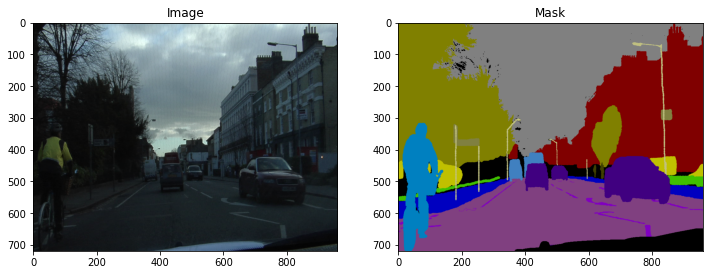

In [12]:
temp = choice(train_pairs)
img = img_to_array(load_img(temp[0]))
mask = img_to_array(load_img(temp[1]))

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.title("Image")
plt.imshow(img/255)
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask/255)

plt.show()

In [13]:
class_map_df = pd.read_csv("/tmp/CamVid/class_dict.csv")
class_map_df.head()

,name,r,g,b,class_11
0,Animal,64,128,64,0
1,Archway,192,0,128,0
2,Bicyclist,0,128,192,1
3,Bridge,0,128,64,0
4,Building,128,0,0,1


In [14]:
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))
    
print(len(class_map))
print(class_map[0])

32
[ 64 128  64]


In [15]:
"""This function will be used later, to assert that mask should contains values that are class labels only.
   Like, our example has 32 classes , so predicted mask must contains values between 0 to 31. 
   So that it can be mapped to corresponding RGB."""
def assert_map_range(mask,class_map):
    mask = mask.astype("uint8")
    for j in range(img_size):
        for k in range(img_size):
            assert mask[j][k] in class_map , tuple(mask[j][k])

In [16]:
'''This method will convert mask labels(to be trained) from RGB to a 2D image whic holds class labels of the pixels.'''
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    
    return label

In [17]:
lab = form_2D_label(mask,class_map)
np.unique(lab,return_counts=True)

(array([ 2,  4,  5,  8, 10, 12, 16, 17, 19, 21, 22, 26, 29, 30, 31],
       dtype=uint8),
 array([ 29757, 118942,  31441,   5167,   3923,   3118,    706, 134906,
         17005, 162530,   4666, 122630,   9716,  41378,   5315]))

In [18]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair,class_map,  batch_size=16, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [k for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = np.asarray(to_categorical(label , num_classes = 32))
       
            batch_labels.append(label)
        return np.array(batch_imgs) ,np.array(batch_labels)

(4, 512, 512, 3) (4, 512, 512, 32)
Images


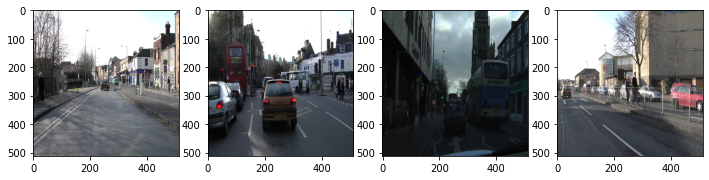

In [19]:
img_size = 512


train_generator1 = DataGenerator(train_pairs,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
X,y = train_generator1.__getitem__(0)
print(X.shape, y.shape)


plt.figure(figsize=(12, 6))
print("Images")
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(X[i])
plt.show()


In [21]:
train_generator = DataGenerator(train_pairs,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
val_generator = DataGenerator(val_pairs, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
test_generator = DataGenerator(test_pairs, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)

In [22]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y
def Unet(h, w, filters, num_classes = 32):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=num_classes, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [23]:
model = Unet(img_size , img_size , 64)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])

In [25]:
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_acc',save_best_only='True', verbose=1)
es = EarlyStopping(monitor='val_acc', patience=10, verbose=0)

In [26]:
train_steps = train_generator.__len__()
val_steps = val_generator.__len__()

print(train_steps, val_steps)

91 25


In [27]:
results = model.fit_generator(train_generator , steps_per_epoch=train_steps ,epochs=30,
                              validation_data=val_generator,validation_steps=val_steps,callbacks=[mc,es],
                             verbose = 1)

Epoch 1/30
91/91 [==============================] - 197s 2s/step - loss: 1.5126 - accuracy: 0.6334 - val_loss: 16.3753 - val_accuracy: 0.3885
Epoch 2/30
91/91 [==============================] - 148s 2s/step - loss: 1.0238 - accuracy: 0.7174 - val_loss: 2.2795 - val_accuracy: 0.4289
Epoch 3/30
91/91 [==============================] - 148s 2s/step - loss: 0.8997 - accuracy: 0.7491 - val_loss: 1.3521 - val_accuracy: 0.6749
Epoch 4/30
91/91 [==============================] - 148s 2s/step - loss: 0.8374 - accuracy: 0.7672 - val_loss: 0.9610 - val_accuracy: 0.7540
Epoch 5/30
91/91 [==============================] - 150s 2s/step - loss: 0.7608 - accuracy: 0.7874 - val_loss: 1.2107 - val_accuracy: 0.6303
Epoch 6/30
91/91 [==============================] - 149s 2s/step - loss: 0.7251 - accuracy: 0.7949 - val_loss: 0.7320 - val_accuracy: 0.7936
Epoch 7/30
91/91 [==============================] - 149s 2s/step - loss: 0.6882 - accuracy: 0.8038 - val_loss: 0.8121 - val_accuracy: 0.7810
Epoch 8/30
9

In [28]:
  model.save('./camvid_unet_model.h5')


In [60]:
trained_model = keras.models.load_model("/content/camvid_unet_model.h5")
# trained_model.evaluate_generator(test_generator, verbose=1)


In [35]:
model.evaluate_generator(test_generator)

[0.6948401927947998, 0.8018593192100525]

In [36]:
x_test, y_test = test_generator.__getitem__(2)
print(x_test.shape, y_test.shape)

(4, 512, 512, 3) (4, 512, 512, 32)


In [37]:
y_pred = trained_model.predict(x_test, verbose = 1, batch_size = 4)
y_pred.shape

1/1 [==============================] - 11s 11s/step


(4, 512, 512, 32)

In [38]:
'''This converts predicted map to RGB labels'''
def map_this(y_pred,class_map):
    y_pred_rgb = np.zeros((y_pred.shape[0],y_pred.shape[1],y_pred.shape[2],3))
    for i in range(y_pred.shape[0]):
        image = np.zeros((y_pred.shape[1],y_pred.shape[2],3))
        for j in range(y_pred.shape[1]):
            for k in range(y_pred.shape[2]):
                image[j,k,:] = class_map[y_pred[i][j][k]]
        y_pred_rgb[i] = image
    return y_pred_rgb

In [58]:
"""This will plot original image, original mask and predicted mask"""
def plot_result(img , title):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    for i in range(4):
        plt.subplot(2, 4, i+1)
        plt.imshow(img[i])
    plt.show()

In [40]:
pred = np.argmax(y_pred, axis=3)
y_pred_rgb = map_this(pred,class_map)
test = np.argmax(y_test, axis=3)
y_test_rgb = map_this(test,class_map)


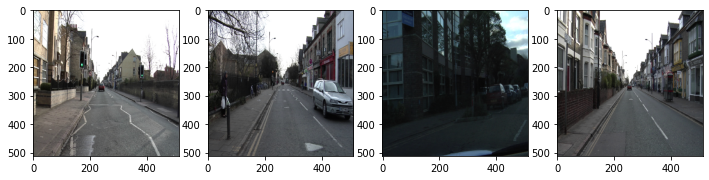

In [59]:
plot_result(x_test,"Test Images")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


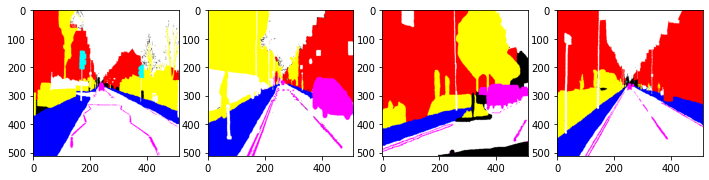

In [42]:
plot_result(y_test_rgb,"Original Masks")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


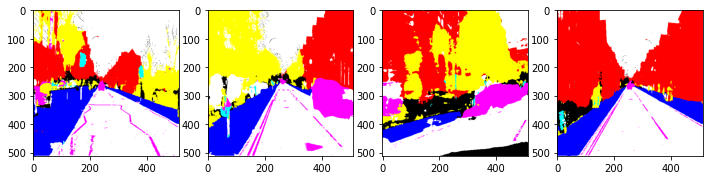

In [43]:
plot_result(y_pred_rgb,"Predicted mask")


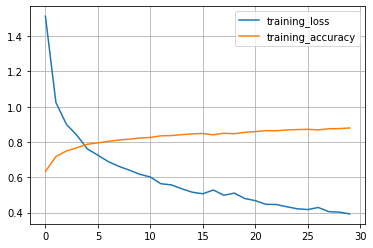

In [44]:
plt.plot(results.history['loss'], label = 'training_loss')
plt.plot(results.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

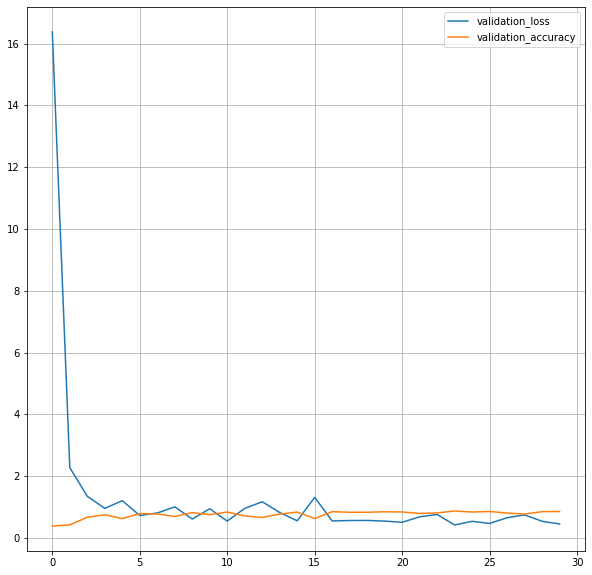

In [49]:
plt.figure(figsize=(10,10))
plt.plot(results.history['val_loss'], label = 'validation_loss')
plt.plot(results.history['val_accuracy'], label = 'validation_accuracy')
plt.legend()

plt.grid(True)